# Lesson S1 - Subsetting the CONUS domain files

## Overview
In this lesson, we will review the subsetting scripts used at NCAR for subsetting the NWM domain files. **NOTE** : since the CONUS files are not available in the training material, this course would be run by instructor on the [Cheyenne system](https://www2.cisl.ucar.edu/resources/computational-systems/cheyenne), and it will not run on the docker container. However, the output files are provided in the example case that will be used hereafter for the upcoming lessons. Here, we will start with an overview of the static domain and parameter files required by NWM, then we will briefly discuss and run the subsetting scripts as an example.

**IMPORTANT NOTE:** Before we provide some explanation about the static files, it is worth mentioning that the name of these files are not hardcoded in the WRF-Hydro/NWM code and it is defined in the namelist.hrldas and hydro.namelist files and can be called anything and therefore you would see different names used by different users. Here, we are using the name of the files provided in the example case to talk about the content of the NWM static domain files. However, keep in mind that naming convention is different from the files on the WCOSS system. 

## NWM Static files

The following table provides the list of the static files that are required for NWM to run (NWM V2.0). 

| Filename | Description | Source | Required for V2.0 |
| ------------- | ------------- | ------------- | ------------- |
| geo_em_d01.nc | The data required to define the domain and geospatial attributes of a spatially-distributed, or gridded, 1-dimensional (vertical) land surface model (LSM) | GEOGRID utility in the WRF preprocessing system (WPS) | Yes |
| wrfinput_d01.nc | file including all necessary fields for the Noah-MP land surface model, but with spatially uniform initial conditions. Users should be aware that the model will likely require additional spin-up time when initialized from this file. | create_Wrfinput.R script | Yes |
| Fulldom_hires.nc | High resolution full domain file. Includes all fields specified on the routing grid. | WRF-Hydro GIS pre-processing toolkit with some custom modification | Yes |
| Route_Link.nc | This file contains all the information and required parameters of reaches required for channel routing | based on the NHDPlus and other custom hydrography dataets | Yes |
| spatialweights.nc | netCDF file specifying the weights to map between the land surface grid and the pre-defined groundwater basin boundaries | custom python script | Yes |
| LAKEPARM.nc | Lake parameter table containing lake model parameters for each catchment | WRF-Hydro GIS pre-processing toolkit | Yes |
| GWBUCKPARM.nc | Groundwater parameter table containing bucket model parameters for each basin | WRF-Hydro GIS pre-processing toolkit | Yes |
| hydro2dtbl.nc | Spatially distributed parameter table for lateral flow routing within WRF-Hydro. | create_SoilProperties.R script (will also be automatically generated by WRF-Hydro) | Yes |
| soil_properties.nc | Spatially distributed land surface model parameters | create_SoilProperties.R script | Yes |
| GEOGRID_LDASOUT_Spatial_Metadata.nc | projection and coordinate information for the land surface model grid. | WRF-Hydro GIS pre-processing toolkit | NO, but allows for CF compliant outputs |
| nudgingParams.nc | The parameter file for the Nudging data assimilation scheme | Rwrfhydro Function | Only if running Nudging |





These files will be explained in more detail in the upcoming lessons and you will tweak some of them in the training lessons. Here, we briefly talk about the content of each file. The National Water Model runs in 4 different configurations.

* Analysis and Assimilation (AnA)
* Short-Range (Forecast)
* Medium-Range (Forecast)
* Long-Range (Forecast)

AnA, Short Range and Medium Range (in V2.0) have the same physics options. The Long Range configuration has slightly different physics options which are runtime options and it does not have the terrain routing compared to full physics. Therefore, some of the files are different between the two options. Below we will mention which files are different between the two options, however, we check out only the content of the Full Physics configuration.  

In general, NWM (Full Physics configuration) proceeds as follows: the 1-dimensional (1D) column land surface model, calculates infiltration and exfiltration on a 1-kilometer grid across the land surface (i.e. LSM grid). These volumes are then disaggregated to a 250 meter “hydro” overland routing grid using a time-step weighted method and the excess water is routed horizontally across a the hydro grid using an overland diffusive wave scheme. This horizontally routed flow is aggregated into catchments at the National Hydrography Database NHD-Plus version 2 (NHD+) medium resolution scale and transferred into the channel network, inserting the flow at the top of the reaches for routing downstream. The process of moving from the hydro grid to the NHD+ catchments is achieved through a mapping process that calculates a spatial weight between each catchment and hydro grid pixel. So all the 2D variables are either on LSM grid (1 km in NWM V2.0) or hydro grid (250 m for Full Physics NWM V2.0 and 1 km for Long Range). 

The figure below shows the diagram of channel network overlaid with the LSM and hydro grids. The mapping between the catchment and its contributing fluxes are shown in the area-weighted grid (right). The traingle shows the location of a lake, and the circle shows the location of a USGS gage, but it is not been used in this lesson. 

![Subsetting_lesson_Figure1.png](lesson_s1_img/Subsetting_lesson_Figure1.png)

### Geogrid File (geo_em_d01.nc)

The data required to define the domain and geospatial attributes of a spatially-distributed, or gridded, 1-dimensional (vertical) land surface model (LSM) are specified in a geogrid (geo_em.d0x.nc) netCDF file. This file is generated by the GEOGRID utility in the WRF preprocessing system (WPS). GEOGRID interpolates land surface terrain, soils and vegetation data from standard, readily available data products. These data are distributed as a geographical input data package via the WRF website. Lets take a look at the content of the file. 

In [6]:
%%bash 
ls ~/DOMAIN/geo_em.d0x.nc

/home/docker/DOMAIN_USB/geo_em.d0x.nc
netcdf geo_em.d0x {
dimensions:
	Time = UNLIMITED ; // (1 currently)
	month = 12 ;
	south_north = 253 ;
	west_east = 278 ;
	land_cat = 24 ;
	west_east_stag = 279 ;
	south_north_stag = 254 ;
	soil_cat = 16 ;
	DateStrLen = 19 ;
variables:
	float ALBEDO12M(Time, month, south_north, west_east) ;
		ALBEDO12M:FieldType = 104 ;
		ALBEDO12M:MemoryOrder = "XYZ" ;
		ALBEDO12M:units = "percent" ;
		ALBEDO12M:description = "Monthly surface albedo" ;
		ALBEDO12M:stagger = "M" ;
		ALBEDO12M:sr_x = 1 ;
		ALBEDO12M:sr_y = 1 ;
	float CLAT(Time, south_north, west_east) ;
		CLAT:FieldType = 104 ;
		CLAT:MemoryOrder = "XY " ;
		CLAT:units = "degrees latitude" ;
		CLAT:description = "Computational latitude on mass grid" ;
		CLAT:stagger = "M" ;
		CLAT:sr_x = 1 ;
		CLAT:sr_y = 1 ;
	float CLONG(Time, south_north, west_east) ;
		CLONG:FieldType = 104 ;
		CLONG:MemoryOrder = "XY " ;
		CLONG:units = "degrees longitude" ;
		CLONG:description = "Computational longitude on mas

This file is on the LSM grid, and has a spatial resolution of 1 km. There are 4608 * 3840 pixels in total, below we display the topography iformation as a sample. We will discuss plotting in the upcoming lessons. 

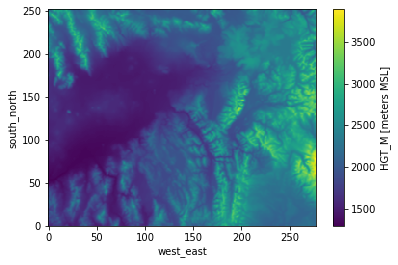

In [7]:
# Import our libraries
%matplotlib inline
import xarray as xr
# Load a dataset
geogrid = xr.open_dataset('~/DOMAIN/geo_em.d0x.nc')
geogrid.HGT_M.plot()

### Wrfinput file (wrfinput_d01.nc)

Initial conditions for the land surface such as soil moisture, soil temperature, and snow states, are prescribed via the wrfinput_d1x.nc file. This netCDF file can be generated one of two ways, through the real.exe program within WRF or via an R script (create_Wrfinput.R) distributed on the WRF-Hydro website. When created using the real.exe program in WRF, initial conditions are pulled from existing reanalysis or realtime products (see WRF documentation for data and system requirements). This will typically result in more realistic initial model states. However, the process is somewhat involved and requires the user to obtain additional external datasets. The R script will create a simplified version of the wrfinput (wrfinput_d1x.nc) file including all necessary fields for the Noah-MP land surface model, but with spatially uniform initial conditions that are prescribed within the script and requires only the geogrid file geo_em.d1x.nc as input. Step-wise instructions and detailed requirements are included in documentation distributed with the script. Users should be aware that the model will likely require additional spin-up time when initialized from this file. 

Now, check out the content of the file. 

In [9]:
%%bash
ncdump -h ~/DOMAIN/wrfinput_d0x.nc

netcdf wrfinput_d0x {
dimensions:
	Time = UNLIMITED ; // (1 currently)
	south_north = 253 ;
	west_east = 278 ;
	soil_layers_stag = 4 ;
variables:
	float CANWAT(Time, south_north, west_east) ;
		CANWAT:units = "kg/m^2" ;
		CANWAT:_FillValue = -1.e+36f ;
	float DZS(Time, soil_layers_stag) ;
		DZS:units = "m" ;
		DZS:_FillValue = -1.e+36f ;
	float HGT(Time, south_north, west_east) ;
		HGT:FieldType = 104 ;
		HGT:MemoryOrder = "XY " ;
		HGT:units = "meters MSL" ;
		HGT:description = "Topography height" ;
		HGT:stagger = "M" ;
		HGT:sr_x = 1 ;
		HGT:sr_y = 1 ;
	int ISLTYP(Time, south_north, west_east) ;
		ISLTYP:FieldType = 104 ;
		ISLTYP:MemoryOrder = "XY " ;
		ISLTYP:description = "Dominant category" ;
		ISLTYP:grid_mapping = "lambert_conformal_conic" ;
		ISLTYP:sr_x = 1 ;
		ISLTYP:sr_y = 1 ;
		ISLTYP:stagger = "M" ;
		ISLTYP:units = "category" ;
		ISLTYP:_FillValue = -9999 ;
	int IVGTYP(Time, south_north, west_east) ;
		IVGTYP:grid_mapping = "lambert_conformal_conic" ;
		IVGTYP:FieldType

This file is on the LSM grid (1 km spatial resolution), and also has another dimension for soil layers. NWM is modeling the soil as 4 layers with the thickness of 10 cm, 30 cm, 60 cm and 1 m from top to bottom. 

### Fulldom File (Fulldom_hires.nc)

This file is on the hydro grid (250 m spatial resolution) and has most of the required fields for the terrain routing. Check out the content of the file. 

In [10]:
%%bash 
ncdump -h ~/DOMAIN/Fulldom_hires.nc

netcdf Fulldom_hires {
dimensions:
	y = 1012 ;
	x = 1112 ;
	string1 = 1 ;
variables:
	short CHANNELGRID(y, x) ;
		CHANNELGRID:grid_mapping = "crs" ;
		CHANNELGRID:coordinates = "x y" ;
		CHANNELGRID:long_name = "CHANNELGRID" ;
		CHANNELGRID:units = "Meter" ;
		CHANNELGRID:missing_value = -32768s ;
		CHANNELGRID:esri_pe_string = "PROJCS[\"Lambert_Conformal_Conic\",GEOGCS[\"GCS_Sphere\",DATUM[\"D_Sphere\",SPHEROID[\"Sphere\",6370000.0,0.0]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Lambert_Conformal_Conic_2SP\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",-97.0],PARAMETER[\"standard_parallel_1\",30.0],PARAMETER[\"standard_parallel_2\",60.0],PARAMETER[\"latitude_of_origin\",40.0],UNIT[\"Meter\",1.0]];-35691800 -29075200 10000;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision" ;
	short FLOWDIRECTION(y, x) ;
		FLOWDIRECTION:grid_mapping = "crs" ;
		FLOWDIRECTION:coordinates = "x y" ;
		FLOWDI

As mentioned earlier, all the variables in this file are on the hydro grid, and therefore the Full Physics configuration has a 250 m spatial resolution and the Long Range configuration has 1 km spatial resolution. Note that some of the parameters are being calibrated in NWM V2.0. 

| Variable Name | Description | Source of the data | 
| ------------- | ------------- | ------------- |
| CHANNELGRID | Channel network grid identifying the location of stream channel grid cells | NHDWaterbodyComID (which matches RouteLink) |
| FLOWDIRECTION | Flow direction grid, which explicitly defines flow directions along the channel network in gridded routing. This variable dictates where water flows into channels from the land surface as well as in the channel. | based on DEM|
| LAKEGRID | - | - | 
| LKSATFAC | Multiplier on lateral hydraulic conductivity (controls anisotropy between vertical and lateral conductivity) (Unitless) |  This parameter is being calibrated in V2.0 |
| OVROUGHRTFAC | Multiplier on Manning's roughness for overland flow | set to 1.0 in NWM V2.0 | |
| RETDEPRTFAC | Multiplier on retention depth limit (Unitless) | This parameter is being calibrated in V2.0 | - |
| STREAMORDER | Strahler stream order grid identifying the stream order for all channel pixels within the channel network | - |
| TOPOGRAPHY | Terrain grid or Digital Elevation Model (DEM), 1 km grid for the Long Range configuration and 250 m grid for the Full Physics |  |
| landuse | landuse | - | 
| LONGITUDE | longitude | - |
| LATITUDE | longitude | - | 
| x | x coordinate of projection | - |
| y | y coordinate of projection | - |
| crs | projection coordinate system | - |
| basn_msk | Basin Mask | Not used in NWM V2.0 |
| frxst_pts | Forecast Points | Not Used in NWM V2.0 |





### Route Link File (Route_Link.nc)

On the linked network, WRF-Hydro/NWM makes use of a fairly standard implementation of the Muskingum-Cunge (MC) method of hydrograph routing which makes use of time varying parameter estimates. But as a one-dimensional explicit scheme, it does not allow for backwater or localized effects. Channel flows are routed upstream to downstream in a cascade routing manner (Gunner and Gorbetch, 1991) with the assumption that there are negligible backwater effects.

The NWM flowline network is built from the National Hydrography Dataset (NHD+v2 dataset). Modifications were made to add external contributing basins (oCONUS) into the model, such as portions of the Columbia and Rio Grande river basins. Gauges are snapped to reaches (links) in the network and the Routelink file serves as the lookup table for parameters and locations of all ~2.7 million reaches. The channels are assumed to be trapezoidal. All the required parameters for the channel routing are provided in the route link file, let's take a look at the content of the file. 

In [11]:
%%bash 
ncdump -h ~/DOMAIN/Route_Link.nc

netcdf Route_Link {
dimensions:
	feature_id = 35529 ;
	IDLength = 15 ;
variables:
	float BtmWdth(feature_id) ;
		BtmWdth:long_name = "Bottom width of channel (m)" ;
		BtmWdth:units = "m" ;
		BtmWdth:coordinates = "lat lon" ;
	float ChSlp(feature_id) ;
		ChSlp:long_name = "Channel side slope" ;
		ChSlp:coordinates = "lat lon" ;
	short Kchan(feature_id) ;
		Kchan:long_name = "channel conductivity" ;
		Kchan:units = "mm h-1" ;
		Kchan:coordinates = "lat lon" ;
	float Length(feature_id) ;
		Length:long_name = "Stream length (m)" ;
		Length:coordinates = "lat lon" ;
	float MusK(feature_id) ;
		MusK:long_name = "Muskingum routing time (s)" ;
		MusK:coordinates = "lat lon" ;
	float MusX(feature_id) ;
		MusX:long_name = "Muskingum weighting coefficient" ;
		MusX:coordinates = "lat lon" ;
	int NHDWaterbodyComID(feature_id) ;
		NHDWaterbodyComID:coordinates = "lat lon" ;
		NHDWaterbodyComID:long_name = "ComID of NHDWaterbody feature associated using spatial join (intersection) between NHDFlowlin

There are 2729077 reaches modeled in the NWM V2.0. In the table below, all the variables in the route link file are being described and the source of the data is provided. 

| Variable Name | Description | Source of the data | 
| ------------- | ------------- | ------------- |
| link | Link ID |  NHD+ |
| from | From Link ID | - |
| to | To Link ID  | - | 
| lon | Longitude of the segment midpoint [degrees east] | - |
| lat | Latitude of the segment midpoint [degrees north] | - |
| alt | Elevation from the NAD88 datum at start node [m] | - |
| order | Strahler stream order | NHD+ |
| Qi | Initial flow in link [m3/s] | - |
| Musk | Muskingum routing time [s] | Default |
| MusX | Muskingum weighting coefficient | Default |
| Length | Stream segment length [m] | NHD+ |
| n | Manning’s roughness | Order based, from 0.04 to 0.06 |
| So | Slope [m/m] | NHD+ |
| ChSlp | Channel side slope [m/m] | Calculated from Tw and BtmWdth
| BtmWdth | Channel bottom width [m] |  Regression, based on drainage area  |
| NHDWaterbodyComID | NHDWaterbodyComID | NHD+ |
| gages | Identifier for stream gage at this locations | - |
| Kchan | Channel conductivity [mm/hr] | Not active |
| ascendingIndex | Index to user for sorting IDs - only in NWM files | - |
| nCC | Compound Channel Manning's n | Default, set to 2 times Manning’s in the channel |
| TopWdthCC | Compound Channel Top Width (m) | Default, set to 3 times TopWdth |
| TopWdth |  Top Width (m) | Regression, based on drainage area |


### Lake Parameter File (LAKEPARM.nc)

All the information about the lakes are stored in the lake parameter file. At this point, there is no active management in the model. Each lake/reservoir in the NWM V2.0 has an orifice and weir assigned to it. The input to the lake will be routed using level pool routing. 


In [12]:
%%bash 
ncdump -h ~/DOMAIN/LAKEPARM.nc # We do not have a lake parm file for the Upper Snake River Basin

ncdump: /home/docker/DOMAIN/LAKEPARM.nc: No such file or directory


CalledProcessError: Command 'b'ncdump -h ~/DOMAIN/LAKEPARM.nc\n'' returned non-zero exit status 1.

Note that there are 5459 lake objects in the NWM V2.0. The table below provides a brief desciption of all the variables in the lake param file. 

| Variable Name | Description | 
| ------------- | ------------- |
| lake_id | NHDWaterbodyComID (which matches RouteLink) |
| LkArea | Area [km2], from NHD+ |
| LkMxE | Elevation of maximum lake height [m, AMSL] |
| OrificeC | Orifice coefficient (ranges from zero to one), set to 0.1 everwhere in NWM V2.0 |
| OrificeA | Orifice area [m2] , set to 1 everywhere in NWM V2.0|
| OrificeE | Orifice elevation [m, AMSL] |
| WeirC | Weir coefficient (ranges from zero to one), set to 0.4 everywhere in NWM V2.0 |
| WeirL | Weir length [m], set to 10 everwhere in NWM V2.0 |
| WeirE | Weir elevation [m, AMSL] |
| ascendingIndex | index to use for sorting IDs (ascending) |
| ifd | Initial fractional depth, as a ratio of how full the lake is, set to 0.9 everwhere in NWM V2.0 |
| lat | Latitude [decimal degrees] |
| lon | Longitude [decimal degrees] |
| crs | projection coordinate system |


### Spatial Weight File (spatialweights.nc)

This file specifies the weights to map between the land surface grid and the pre-defined groundwater basin boundaries. This file is used in the subsetting of the files. There are two spatial weight files, one for the full physics and one for the long range configuration as the hydro resolution differs between the two configurations. Let's take a look at the content of the file. 

In [13]:
%%bash 
ncdump -h ~/DOMAIN/spatialweights.nc

netcdf spatialweights {
dimensions:
	data = 1467306 ;
	polyid = 24052 ;
variables:
	int IDmask(data) ;
		IDmask:long_name = "Polygon ID (polyid) associated with each record" ;
	int i_index(data) ;
		i_index:long_name = "Index in the x dimension of the raster grid (starting with 1,1 in LL corner)" ;
	int j_index(data) ;
		j_index:long_name = "Index in the y dimension of the raster grid (starting with 1,1 in LL corner)" ;
	int overlaps(polyid) ;
		overlaps:long_name = "Number of intersecting polygons" ;
	int polyid(polyid) ;
		polyid:long_name = "ID of polygon" ;
	double regridweight(data) ;
		regridweight:long_name = "fraction of intersecting polyid(overlapper) intersected by polygon(polyid)" ;
	double weight(data) ;
		weight:long_name = "fraction of polygon(polyid) intersected by polygon identified by poly2" ;

// global attributes:
		:history = "Fri Apr 14 10:23:15 2023: ncks -O -d polyid,1,24052 -d data,1,1467306 /glade/work/arezoo/Idaho/USB_Entire_Domain/spatialweights.nc /glade/wor

Note that there are 2677135 polygon IDs in this file which matches the number of NHD basins and consequently the groundwater basins in NWM V2.0. 

| Variable Name | Description | 
| ------------- | ------------- |
| polyid | ID of polygon | 
| IDmask | Polygon ID (polyid) associated with each record) |
| overlaps | Number of intersecting polygons |
| weight | Fraction of intersecting polygon(polyid) intersected by poly2 |
| regridweight | Fraction of intersecting polyid(overlapper) intersected by polygon(polyid) |
| i_index | Index in the x dimension of the raster grid (starting with 1,1 in the LL corner) |
| j_index | Index in the y dimension of the raster grid (starting with 1,1 in the LL corner) |

### Groundwater Bcuket Parameter File (GWBUCKPARM.nc)

This file contains the groundwater parameters governing the behavior of the bucket model parameterization for each groundwater/baseflow basin specified within the model domain. In NWM V2.0, the groundwater basins match the NHD basins. Two of the varriables in this file have been calibrated in NWM V2.0. Since there were two separate calibrations run for the Full Physics and Long Range configuration, therefore there exist two soil properites files, one for Full Physics and one for the Long Range configuration. Lets take a look at the content of the soil properties file for the Full Physics configuration.

In [14]:
%%bash 
ncdump -h ~/DOMAIN/GWBUCKPARM.nc

netcdf GWBUCKPARM {
dimensions:
	BasinDim = 24052 ;
variables:
	float Area_sqkm(BasinDim) ;
		Area_sqkm:long_name = "Basin area in square kilometers" ;
	int Basin(BasinDim) ;
		Basin:long_name = "Basin monotonic ID (1...n)" ;
	float Coeff(BasinDim) ;
		Coeff:long_name = "Coefficient" ;
	int ComID(BasinDim) ;
		ComID:long_name = "NHDCatchment FEATUREID (NHDFlowline ComID)" ;
	float Expon(BasinDim) ;
		Expon:long_name = "Exponent" ;
	float Loss(BasinDim) ;
		Loss:units = "-" ;
		Loss:long_name = "Fraction of bucket output lost" ;
	float Zinit(BasinDim) ;
		Zinit:long_name = "Zinit" ;
	float Zmax(BasinDim) ;
		Zmax:long_name = "Zmax" ;

// global attributes:
		:featureType = "point" ;
		:history = "Fri Apr 14 10:23:17 2023: ncks -O -d BasinDim,1,24052 /glade/work/arezoo/Idaho/USB_Entire_Domain/GWBUCKPARM.nc /glade/work/arezoo/Idaho/USB_Entire_Domain/GWBUCKPARM.nc\nCreated Mon Sep 13 11:05:38 2021" ;
		:NCO = "netCDF Operators version 4.9.5 (Homepage = http://nco.sf.net, Code = http://gith

There are 2677135 grounwater basins in the NWM domain that matches the number of NHD basins being modeled in NWM V2.0. 

| Variable Name | Description | Calibrated in V2.0 | 
| ------------- | ------------- | ------------- | 
| Basin | Basin monotonic ID (1...n) | - |
| Coeff | Bucket model coefficient | - |
| expon | Exponent controlling rate of bucket drainage as a function of depth | Yes |
| Zmax | Maximum groundwater bucket depth (mm) | Yes |
| Zinit | Initial depth of water in the bucket model | No, set to 10 for all the basins | 
| Area_sqkm | Basin area in square kilometers | - | 
| ComID | NHDCatchment FEATUREID (NHDFlowline ComID) | - |


### Soil Properties File (soil_properties.nc)

This file contains all the spatially varying soil and vegetation parameters. Some of the varriables in this file have been calibrated in NWM V2.0. Since there were two separate calibrations for the Full Physics and Long Range configuration, therefore there exist two soil properites files, one for Full Physics and one for the Long Range configuration. Let's take a look at the content of the soil properties file for the Full Physics configuration. 


In [15]:
%%bash 
ncdump -h ~/DOMAIN/soil_properties.nc

netcdf soil_properties {
dimensions:
	Time = UNLIMITED ; // (1 currently)
	south_north = 253 ;
	west_east = 278 ;
	soil_layers_stag = 4 ;
variables:
	float AXAJ(Time, south_north, west_east) ;
		AXAJ:_FillValue = -9999.f ;
	float BXAJ(Time, south_north, west_east) ;
		BXAJ:_FillValue = -9999.f ;
	float XXAJ(Time, south_north, west_east) ;
		XXAJ:_FillValue = -9999.f ;
	float bexp(Time, soil_layers_stag, south_north, west_east) ;
		bexp:_FillValue = -9999.f ;
	float cwpvt(Time, south_north, west_east) ;
		cwpvt:_FillValue = -9999.f ;
	float dksat(Time, soil_layers_stag, south_north, west_east) ;
		dksat:_FillValue = -9999.f ;
	float dwsat(Time, soil_layers_stag, south_north, west_east) ;
		dwsat:_FillValue = -9999.f ;
	float hvt(Time, south_north, west_east) ;
		hvt:_FillValue = -9999.f ;
	float imperv(south_north, west_east) ;
		imperv:RepresentationType = "ATHEMATIC" ;
		imperv:grid_mapping = "lambert_conformal_conic" ;
		imperv:long_name = "GDAL Band Number 1" ;
	char lambert_conform

Note, that this file is on the coarse 1 km resolution. Below we have summarized all the variables with a short description of each parameter. Note, that for the parameters that have the soil layer as a dimension, the same variables have been used for all the soil layers. 

| Variable Name | Description | Calibrated in V2.0 | 
| ------------- | ------------- | ------------- | 
| bexp | Beta parameter | Yes |
| cwpvt | Empirical canopy wind parameter | Yes |
| dksat | Saturated soil hydraulic conductivity | Yes |
| dwsat | Saturated soil hydraulic diffusivity | No |
| hvt | Top of vegetation canopy [m] | No |
| mfsno | Snowmelt m parameter | Yes |
| mp | Slope of conductance to photosynthesis relationship | Yes |
| psisat | Saturated soil matric potential | No |
| quartz | Soil quartz content | No |
| refdk | Parameter in the surface runoff parameterization. A reference for soil conductivity | No |
| refkdt | Parameter in the surface runoff parameterization. A soil infiltration parameter | Yes |
| slope | Slope index | Yes |
| smcdry | Dry soil moisture threshold where direction evaporation from the top layer ends | No |
| smcmax | Saturated value of soil moisture [volumetric] | Yes |
| smcref | Reference soil moisture (field capacity) [volumetric] | No |
| smcwlt | Wilting point soil moisture [volumetric] | No |
| vcmx25 | Maximum rate of carboxylation at 25 C [umol CO2/m2/s] | Yes |
| rsurfexp |??? | Yes |


### Hydro 2D File (hydro2dtbl.nc)

This file contains all the spatially varying parameters for the lateral routing. Some of the variables in this file have been calibrated in NWM V2.0. Again, since there were two separate calibrations for the Full Physics and Long Range configuration, therefore there exist two hydro 2D files, one for Full Physics and one for the Long Range configuration. Let s take a look at the content of the hydro 2D file for the Full Physics configuration. 


In [16]:
%%bash
ncdump -h ~/DOMAIN/hydro2dtbl.nc

netcdf hydro2dtbl {
dimensions:
	south_north = 253 ;
	west_east = 278 ;
variables:
	float LKSAT(south_north, west_east) ;
		LKSAT:_FillValue = -9999.f ;
	float NEXP(south_north, west_east) ;
		NEXP:_FillValue = -9999.f ;
	float OV_ROUGH2D(south_north, west_east) ;
		OV_ROUGH2D:_FillValue = -9999.f ;
	float SMCMAX1(south_north, west_east) ;
		SMCMAX1:_FillValue = -9999.f ;
	float SMCREF1(south_north, west_east) ;
		SMCREF1:_FillValue = -9999.f ;
	float SMCWLT1(south_north, west_east) ;
		SMCWLT1:_FillValue = -9999.f ;

// global attributes:
		:TITLE = "OUTPUT FROM GEOGRID V3.6" ;
		:SIMULATION_START_DATE = "0000-00-00_00:00:00" ;
		:WEST-EAST_GRID_DIMENSION = 279 ;
		:SOUTH-NORTH_GRID_DIMENSION = 254 ;
		:BOTTOM-TOP_GRID_DIMENSION = 0 ;
		:WEST-EAST_PATCH_START_UNSTAG = 1 ;
		:WEST-EAST_PATCH_END_UNSTAG = 278 ;
		:SOUTH-NORTH_PATCH_START_UNSTAG = 1 ;
		:SOUTH-NORTH_PATCH_END_UNSTAG = 253 ;
		:GRIDTYPE = "C" ;
		:DX = 1000.f ;
		:DY = 1000.f ;
		:DYN_OPT = 2 ;
		:CEN_LAT = 40.00001f ;
		

Note the variables are on the coarse 1km resolution, and are all 2D variables. Below the table of the variables with a short description is provided. Two of these parameters have been calibrated in the NWM V2.0. 

| Variable Name | Description | Calibrated in V2.0 | 
| ------------- | ------------- | ------------- | 
| SMCMAX1 | Maximum volumetric soil moisture [m3/m3] | Yes, this is the same as `scmax` in soil propoerties file |
| SMCREF1 | Reference volumetric soil moisture [m3/m3] | No |
| SMCWLT1 | Wilting point volumetric soil moisture [m3/m3] | No |
| OV_ROUGH2D | Overland flow roughness coefficient | No | 
| LKSAT | Lateral saturated soil hydraulic conductivity [m/s] | Yes, this is the same as `DKSAT` in soil properties file |


### GEOGRID_LDASOUT_Spatial_Metadata.nc (GEOGRID_LDASOUT_Spatial_Metadata.nc)

This file contains projection and coordinate information for the land surface model grid. It has three variables of x, y on the coarse 1km resolution grid and crs indicating the projection coordinate system for the output files. 


In [17]:
%%bash
ncdump -h ~/DOMAIN/GEOGRID_LDASOUT_Spatial_Metadata.nc

netcdf GEOGRID_LDASOUT_Spatial_Metadata {
dimensions:
	x = 278 ;
	y = 253 ;
variables:
	char crs ;
		crs:transform_name = "lambert_conformal_conic" ;
		crs:grid_mapping_name = "lambert_conformal_conic" ;
		crs:esri_pe_string = "PROJCS[\"Lambert_Conformal_Conic\",GEOGCS[\"GCS_Sphere\",DATUM[\"D_Sphere\",SPHEROID[\"Sphere\",6370000.0,0.0]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Lambert_Conformal_Conic_2SP\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",-97.0],PARAMETER[\"standard_parallel_1\",30.0],PARAMETER[\"standard_parallel_2\",60.0],PARAMETER[\"latitude_of_origin\",40.0],UNIT[\"Meter\",1.0]];-35691800 -29075200 10000;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision" ;
		crs:spatial_ref = "PROJCS[\"Lambert_Conformal_Conic\",GEOGCS[\"GCS_Sphere\",DATUM[\"D_Sphere\",SPHEROID[\"Sphere\",6370000.0,0.0]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Lambert_

## How to subset the NWM domain files to a smaller domain

There are two ways to subset the NWM domains. 
1. Subsetting using the bounding box coordinates
2. Subsetting using tracing a gages or a comId 

### Requirements

R (rwrfhydro, ncdf4, sp, raster, stringr, plyr libraries)

NCO (ncks, and ncatted commands are used)

### Subset using bounding box coordinates

This was the first attempt to subset the domain done by Aubrey Dugger. This is the methodology adopted by CUAHSI in order to provide web service for cutting out the NWM files. For this method, user provides x and y coordinates from the GEOGRID file projection system, which is currently the Lambert Conformal Conic. Then, the relative indices (west, east, south, north) in the original GEOGIRD (coarse grid) and Fulldom (fine grid) file will be calculated. These indices are directly used in clipping the GEOGRID, Wrfinput, and Fulldom, soil properties, hydro 2D file. 
Then all the links and catchments which fall in the rectangle domain (clip) are identified and will be used in subsetting the Routelink, spatial weight, groundwater bucket and spatial weight files. 


### Subset using tracing a gage or a comId 

The second method to subset the NWM domain files is to provide the gage id or the comId of the outlet reach of the basin. Of course, then this method will only work for the basins that have a single outlet. One could modify the script to work for multiple outlet locations, if required. 

Here, user provides a list of gageIds/comIds. If the gageId/comId does not exist in the Routlink file, it will give a warning and continue with the ones that exist in the Routlink file and provide one cutout per reach (outlet point of the basin). 

First, we trace all the links/reaches about the outlet that drain to the outlet reach. The upstream tracing is performed using three supplementary files that are derived based on the route link file. The three indexing files are unique to the original route link file and if there is a change to the original route link these files should be regenerated. (These indexing files were created by James McCreight.) 

After we have all the contributing reaches, we will find out the bounding box around the basin with the help of spatial weight file. The Spatial weight file has all the pixels that cover a comId (NhD basin). Note, the spatial weight file is different for the Full Physics and Long Range configuration, use the appropriate file. s

After the indices are derived, the rest of the procedure will be similar to subsetting using the bounding box coordinates. All the indices used in the subsetting are written into a default text file named "params.txt". The user can change the naming of this file.

Finally, a script will be prepared for the FORCING subsetting. It is designed to work with NLDAS (LDASIN) FORCING data files, but will require editing to work for other FORCING data files.

### How to create the indexing files:

As mentioned earlier, we need three extra files for subsetting. There is an R function available in rwrfhydro library to create these files. The following lines of Rscript will create three files in where the Routlink file resides. Note: This can be a time consuming process. For the CONUS this needs 32 cores, with 12 hour wall clock approximately.

`library(rwrfhydro) # This is the R package develope by the WRF-Hydro team`

`routlinkFile <- PATH/TO/Route_Link.nc/File`

`ReExpressRouteLink(routlinkFile, parallel = TRUE)`


## Script for subsetting the example case 

All the scripts used for providing the RFC specific cutouts are distributed with the course materials. We have placed the script used in providing the example case in this training in the docker image. Let's take a look at the supplementary directory first.

In [1]:
%%bash 
ls ~/wrf_hydro_training/lessons/training/subsetting_scripts/

subset_domain.R
Utils_ReachFiles.R


 `subset_domain.R` is the main script that calls `Utils_ReachFiles.R` script. `Utils_ReachFiles.R` has some of the utility functions. Let's check out the content of the subsetting script quickly. 

In [2]:
%%bash 
cat ~/wrf_hydro_training/lessons/training/subsetting_scripts/subset_domain.R | head -n 100

#*****************************************  Script description  ****************************************************************************
#
# This script is being modified to minimize the manual work required for the massive subsetting (for the second round of calibration)
# The only input required aside from the model domain files and properites is either a list of comIDs, or a list of gagesID, 
# If the gage does not exists in the Routlink file, it just throws a warning and continue with the subsetting the gauges which exists in the Routlink file
#
#*********************************************************************************************************************************************
library(data.table)
library(rwrfhydro)
library(ncdf4)
source("Utils_ReachFiles.R")
library(raster)
library(foreach)

#------------------------------------------ INPUTS : Please change the following parts as instructed ------------------------------------------

# Specify your new domain file dire

## how to run the subsetting script

The user is required to provide the following:
* The path to your NEW subset domain file directory
* List of gageIds of comIds, it will create one clipped basin for each gageId/comId
* Path to the ORIGINAL (full extent) domain files (for Fulldom, GEOGRID, Wrfinput, Routelink, spatial weight, groundwater bucket parameter, lake parameter and soil parameter files and ...)
* Path to the indexing file (downstreamReExpFile, upstreamReExpFile and reIndFile)
* dxy : the multiplier between routing grid and LSM grid (4 for Full Physics and 1 for Long Range)

In [4]:
%%bash
mkdir -p ~/wrf_hydro_training/output/subsetting/
cd ~/wrf_hydro_training/lessons/training/subsetting_scripts/
Rscript subset_domain.R

Created the following files: 
/home/docker/DOMAIN/Route_Link.reInd.Rdb
/home/docker/DOMAIN/Route_Link.reExpFrom.Rdb
/home/docker/DOMAIN/Route_Link.reExpTo.Rdb
/home/docker/DOMAIN/Route_Link.reExp.nc
[1] "to"
[1] "from"
[1] "reInd"
[1] TRUE
[1] "ncks -O -d x,206,254 -d y,37,89 ~/DOMAIN/GEOGRID_LDASOUT_Spatial_Metadata.nc ~/wrf_hydro_training/output/subsetting//13010065/GEOGRID_LDASOUT_Spatial_Metadata.nc"
[1] "ncatted -O -a GeoTransform,crs,o,c,'-1058999.125 1000 0 572999.6875 0 1000' ~/wrf_hydro_training/output/subsetting//13010065/GEOGRID_LDASOUT_Spatial_Metadata.nc"
[1] "ncks -O -d x,824,1019 -d y,148,359 ~/DOMAIN/Fulldom_hires.nc ~/wrf_hydro_training/output/subsetting//13010065/Fulldom_hires.nc"
[1] "ncatted -O -a GeoTransform,crs,o,c,'-1058999.17655 250 0 572999.66329 0 250' ~/wrf_hydro_training/output/subsetting//13010065/Fulldom_hires.nc"
[1] "ncks -O -d west_east,206,254 -d south_north,163,215 -d west_east_stag,206,255 -d south_north_stag,163,216 ~/DOMAIN/geo_em.d0x.nc ~/wrf_hyd

To check rwrfhydro updates run: CheckForUpdates()
Loading required package: sp
Loading required package: rgdal
Please note that rgdal will be retired during 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2022/04/12/evolution.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-6, (SVN revision 1201)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /usr/share/proj
Linking to sp version:1.6-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.
Warning message:
PROJ support is provided by the sf and terra packages among others 
Warning message:
PROJ

The script will create one folder for each cutout basin, the name of the folder would be the USGS gage identifier if the gageId was provided, otherwise the comId of the outlet NHD reach. Now lets check the output directory content. 

In [ ]:
%%bash 
ls ~/nwm-training/output/subsetting/13010065/

We will check out the content of these files in the upcoming lessons. 

© UCAR 2019